# 🎯 Complete Feature Analysis - ALL Datasets Combined
## Combining All 6 Datasets & Analyzing Which Features Are Best

**Goal:** 
1. Combine ALL 6 datasets into ONE comprehensive dataset
2. Get ALL features together
3. Analyze which features have the best quality
4. See which features work together (correlations)
5. Identify the best features for modeling

---

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


---
## 📂 Section 1: Load ALL Datasets

First, let's load all 6 datasets.

In [9]:
import os
import glob

# Check multiple possible locations for the files
possible_paths = [
    '.',  # Current directory
    '/mnt/user-data/uploads/',  # Uploads folder
    '../',  # Parent directory
    os.path.expanduser('~/Downloads/')  # User's downloads folder
]

print("🔍 Scanning for dataset files...\n")
print("="*80)

all_files = []
data_path = None

# Find which path has the files
for path in possible_paths:
    if os.path.exists(path):
        files_found = glob.glob(os.path.join(path, '*.xlsx')) + \
                      glob.glob(os.path.join(path, '*.xls')) + \
                      glob.glob(os.path.join(path, '*.csv'))
        if files_found:
            all_files = files_found
            data_path = path
            print(f"✅ Found files in: {os.path.abspath(path)}\n")
            break

if not all_files:
    print("❌ No files found! Please check file locations.")
else:
    print(f"Found {len(all_files)} files:\n")
    for f in all_files:
        print(f"  📄 {os.path.basename(f)}")

# Define patterns to identify each dataset type
dataset_patterns = {
    'trip_flight': ['trip', 'flight'],
    'deelnemer': ['deelnemer'],
    'reizen_riss': ['reizen', 'riss'],
    'overzicht_cax': ['overzicht', 'cax'],
    'boekingen_total': ['boekingen', 'total'],
    'grip_freeze': ['grip', 'freeze']
}

# Match files to dataset types
files = {}
for file in all_files:
    filename = os.path.basename(file).lower()
    
    for dataset_name, patterns in dataset_patterns.items():
        # Check if all patterns are in the filename
        if all(pattern in filename for pattern in patterns):
            files[dataset_name] = file
            break

datasets = {}

print("\n" + "="*80)
print("Loading all datasets...\n")
print("="*80)

for name, file in files.items():
    try:
        if file.endswith('.csv'):
            # Try different encodings for CSV
            try:
                df = pd.read_csv(file, encoding='utf-8')
            except:
                try:
                    df = pd.read_csv(file, encoding='latin-1')
                except:
                    try:
                        df = pd.read_csv(file, encoding='utf-8', on_bad_lines='skip')
                    except:
                        df = pd.read_csv(file, encoding='ISO-8859-1')
        else:
            df = pd.read_excel(file)
        
        # Skip useless pivot tables
        if len(df.columns) <= 2 and 'Unnamed' in ' '.join(df.columns):
            print(f"⚠️  {name}: Skipped (pivot table, not useful)")
            continue
            
        datasets[name] = df
        print(f"✅ {name}: {len(df):,} rows × {len(df.columns)} columns")
    except Exception as e:
        print(f"❌ {name}: ERROR - {e}")

print("="*80)
print(f"\n✅ Successfully loaded {len(datasets)} datasets!\n")

if len(datasets) == 0:
    print("⚠️  WARNING: No datasets loaded!")
    print(f"\n📂 Files found but not matched: {len(all_files) - len(files)}")
    if all_files and not files:
        print("\n💡 Try adjusting the pattern matching. Found these files:")
        for f in all_files:
            print(f"   - {os.path.basename(f)}")

🔍 Scanning for dataset files...

✅ Found files in: C:\Users\Anton\Downloads

Found 7 files:

  📄 Export boekingen total RISS 31-12-2024 - fontys.xlsx
  📄 export reizen Riss 31-12-2025-fontys.xlsx
  📄 Grip export booking freeze 1 wk-fontys.xlsx
  📄 Overzicht reizen vanuit cax-GV vertrek juni 2025 en verder - fontys.xlsx
  📄 export_Deelnemer boekingen_Vertrekkend januari 2025-fontys.xls
  📄 Exersice Alpha Corporation.csv
  📄 trip-overview-flight-20251013010007-fontys.csv

Loading all datasets...

✅ boekingen_total: 23,463 rows × 27 columns
⚠️  reizen_riss: Skipped (pivot table, not useful)
✅ grip_freeze: 26,870 rows × 23 columns
✅ overzicht_cax: 1,545 rows × 33 columns
✅ deelnemer: 1,607 rows × 15 columns
✅ trip_flight: 1,340 rows × 1 columns

✅ Successfully loaded 5 datasets!



---
## 🔗 Section 2: Identify Common Keys for Joining

Let's find columns that can connect the datasets together.

In [10]:
print("\n" + "="*80)
print("🔍 ANALYZING JOIN POSSIBILITIES")
print("="*80)

# Show columns for each dataset
for name, df in datasets.items():
    print(f"\n{name}:")
    print(f"  Columns: {', '.join(df.columns[:15].tolist())}")
    if len(df.columns) > 15:
        print(f"           ... and {len(df.columns) - 15} more")

# Find common column names
all_columns = {name: set(df.columns) for name, df in datasets.items()}

print("\n" + "="*80)
print("🔗 COMMON COLUMNS ACROSS DATASETS:")
print("="*80)

# Check for booking IDs or codes that might join datasets
potential_keys = []

# Look for common patterns in column names
key_patterns = ['ID', 'id', 'code', 'Code', 'nummer', 'booking', 'Booking', 'reis', 'Reis']

for ds1_name, cols1 in all_columns.items():
    for ds2_name, cols2 in all_columns.items():
        if ds1_name >= ds2_name:  # Skip duplicates
            continue
        
        common = cols1 & cols2
        if common:
            print(f"\n{ds1_name} ↔ {ds2_name}:")
            print(f"  Common: {', '.join(sorted(common))}")
            potential_keys.extend(list(common))

potential_keys = list(set(potential_keys))
print(f"\n📌 Potential join keys found: {', '.join(potential_keys) if potential_keys else 'None'}")
print("="*80)


🔍 ANALYZING JOIN POSSIBILITIES

boekingen_total:
  Columns: EXPORT, BoekingsID, Code, Reiscode, Label, Land, Regio, Agent alg., ReisleiderType, TypeReisleiderOmschrijving, Reis Omschrijving, Vertrekdat., AantalDagen, BoekingsNummer, Status (Boeking)
           ... and 12 more

grip_freeze:
  Columns: rapportageweek, nw boekjaar, CATEGORIE, VERTREKMAAND, BOEKJAAR, OMZET, boekingsnummer, registratiedatum, startdatum, boekingsbedrag, land, elementtype, elementnaam, aantal_deelnemers, boekingsstatus
           ... and 8 more

overzicht_cax:
  Columns: Expprt date, ID, Departure NL, Bestemmingscode, Code, Label, Dagen, Omschrijving, Min. leeftijd, Opmerking Internet, Status, PAX, Volgt, Aanvr, Options
           ... and 18 more

deelnemer:
  Columns: reis naam, boekingsnummer, registratiedatum, startdatum, einddatum, boekingsbedrag, boekingswaarde deelnemer, land, elementtype hoofdelement, status boeking, geslacht, nationaliteit, leeftijd tijdens reis, geboortedatum, boekingselement code



---
## 🎯 Section 3: Create ONE Combined Dataset with ALL Features

Let's merge all datasets to get ALL features in one place!

In [11]:
print("\n" + "="*80)
print("🎯 CREATING COMBINED DATASET WITH ALL FEATURES")
print("="*80)

# Strategy: Start with the largest dataset and try to merge others
# If merging fails, we'll add datasets as separate rows (concatenate)

# Find largest dataset
largest_name = max(datasets.keys(), key=lambda k: len(datasets[k]))
combined = datasets[largest_name].copy()

print(f"\n🏁 Starting with largest dataset: {largest_name}")
print(f"   Initial: {len(combined):,} rows × {len(combined.columns)} columns\n")

merged_datasets = [largest_name]
failed_merges = []

for name, df in datasets.items():
    if name == largest_name:
        continue
    
    # Find best join key
    common_cols = list(set(combined.columns) & set(df.columns))
    
    if not common_cols:
        print(f"⚠️  {name}: No common columns, will add separately")
        failed_merges.append(name)
        continue
    
    # Try each common column as join key
    best_key = None
    best_match_pct = 0
    
    for col in common_cols:
        try:
            # Calculate overlap
            combined_values = set(combined[col].dropna().unique())
            df_values = set(df[col].dropna().unique())
            overlap = len(combined_values & df_values)
            match_pct = (overlap / max(len(combined_values), len(df_values))) * 100
            
            if match_pct > best_match_pct:
                best_match_pct = match_pct
                best_key = col
        except:
            continue
    
    if best_key and best_match_pct > 10:  # At least 10% overlap
        print(f"✅ Merging {name} on '{best_key}' ({best_match_pct:.1f}% match)")
        try:
            before_cols = len(combined.columns)
            combined = combined.merge(
                df, 
                on=best_key, 
                how='outer',  # Keep all rows
                suffixes=('', f'_{name}')
            )
            new_cols = len(combined.columns) - before_cols
            print(f"   → Added {new_cols} new features")
            merged_datasets.append(name)
        except Exception as e:
            print(f"   ❌ Merge failed: {e}")
            failed_merges.append(name)
    else:
        print(f"⚠️  {name}: Poor match quality ({best_match_pct:.1f}%), will add separately")
        failed_merges.append(name)

print("\n" + "="*80)
print(f"\n✅ Merged datasets: {', '.join(merged_datasets)}")

# For datasets that couldn't be merged, add them as separate rows
if failed_merges:
    print(f"\n📦 Adding remaining datasets as separate rows...\n")
    
    for name in failed_merges:
        df = datasets[name]
        # Align columns - add missing columns
        for col in combined.columns:
            if col not in df.columns:
                df[col] = np.nan
        for col in df.columns:
            if col not in combined.columns:
                combined[col] = np.nan
        
        # Concatenate
        combined = pd.concat([combined, df[combined.columns]], ignore_index=True)
        print(f"✅ Added {name}: +{len(df):,} rows")

print("\n" + "="*80)
print("\n🎉 FINAL COMBINED DATASET:")
print(f"   Total rows: {len(combined):,}")
print(f"   Total features: {len(combined.columns)}")
print(f"   Memory: {combined.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("="*80)


🎯 CREATING COMBINED DATASET WITH ALL FEATURES

🏁 Starting with largest dataset: grip_freeze
   Initial: 26,870 rows × 23 columns

⚠️  boekingen_total: No common columns, will add separately
⚠️  overzicht_cax: No common columns, will add separately
⚠️  deelnemer: Poor match quality (8.7%), will add separately
⚠️  trip_flight: No common columns, will add separately


✅ Merged datasets: grip_freeze

📦 Adding remaining datasets as separate rows...

✅ Added boekingen_total: +23,463 rows
✅ Added overzicht_cax: +1,545 rows
✅ Added deelnemer: +1,607 rows
✅ Added trip_flight: +1,340 rows


🎉 FINAL COMBINED DATASET:
   Total rows: 54,825
   Total features: 89
   Memory: 110.23 MB


---
## 📊 Section 4: Analyze ALL Features Together

Now let's analyze the quality of ALL features in our combined dataset!

In [12]:
print("\n" + "="*80)
print("📊 ANALYZING ALL FEATURES")
print("="*80)

# Comprehensive feature analysis
feature_analysis = []

for col in combined.columns:
    # Basic metrics
    total = len(combined)
    missing = combined[col].isna().sum()
    missing_pct = (missing / total) * 100
    present = total - missing
    present_pct = 100 - missing_pct
    
    # Unique values
    unique = combined[col].nunique()
    unique_pct = (unique / present) * 100 if present > 0 else 0
    
    # Data type
    dtype = str(combined[col].dtype)
    
    # Determine feature type
    if 'int' in dtype or 'float' in dtype:
        feature_type = 'Numeric'
    elif 'datetime' in dtype:
        feature_type = 'DateTime'
    else:
        feature_type = 'Categorical'
    
    # Quality scoring
    # 1. Completeness (70% weight) - lower missing is better
    completeness_score = present_pct
    
    # 2. Usefulness (30% weight) - good variety, not too unique
    if unique <= 1:
        usefulness_score = 0  # Constant, useless
    elif unique_pct > 95:
        usefulness_score = 40  # Likely ID, less useful
    elif 1 < unique_pct <= 50:
        usefulness_score = 100  # Sweet spot!
    else:
        usefulness_score = 70
    
    quality_score = (completeness_score * 0.7) + (usefulness_score * 0.3)
    
    # Recommendation
    if quality_score >= 80 and missing_pct < 30:
        recommendation = "✅ EXCELLENT"
        color = 'green'
    elif quality_score >= 60 and missing_pct < 50:
        recommendation = "🟢 GOOD"
        color = 'lightgreen'
    elif quality_score >= 40:
        recommendation = "🟡 FAIR"
        color = 'yellow'
    else:
        recommendation = "❌ POOR"
        color = 'red'
    
    feature_analysis.append({
        'Feature': col,
        'Type': feature_type,
        'Data Type': dtype,
        'Present': present,
        'Missing': missing,
        'Missing %': missing_pct,
        'Unique': unique,
        'Unique %': unique_pct,
        'Quality Score': quality_score,
        'Recommendation': recommendation,
        'Color': color
    })

# Create DataFrame
features_df = pd.DataFrame(feature_analysis)
features_df = features_df.sort_values('Quality Score', ascending=False)

# Display formatted table
display_df = features_df[['Feature', 'Type', 'Missing %', 'Unique', 'Quality Score', 'Recommendation']].copy()
display_df['Missing %'] = display_df['Missing %'].apply(lambda x: f"{x:.1f}%")
display_df['Quality Score'] = display_df['Quality Score'].apply(lambda x: f"{x:.1f}")

print("\n🏆 ALL FEATURES RANKED BY QUALITY:\n")
print(display_df.to_string(index=False))

# Summary
excellent = len(features_df[features_df['Recommendation'] == '✅ EXCELLENT'])
good = len(features_df[features_df['Recommendation'] == '🟢 GOOD'])
fair = len(features_df[features_df['Recommendation'] == '🟡 FAIR'])
poor = len(features_df[features_df['Recommendation'] == '❌ POOR'])

print("\n" + "="*80)
print("\n📈 FEATURE QUALITY SUMMARY:")
print(f"   ✅ EXCELLENT (>80 quality, <30% missing): {excellent} features")
print(f"   🟢 GOOD (>60 quality, <50% missing): {good} features")
print(f"   🟡 FAIR (>40 quality): {fair} features")
print(f"   ❌ POOR (<40 quality): {poor} features")
print(f"\n   💡 RECOMMENDED FOR MODELING: {excellent + good} features")
print("="*80)


📊 ANALYZING ALL FEATURES

🏆 ALL FEATURES RANKED BY QUALITY:

                                                                                                                                                                                                                                                                        Feature        Type Missing %  Unique Quality Score Recommendation
                                                                                                                                                                                                                                                                     startdatum    DateTime     48.1%     691          66.4         🟢 GOOD
                                                                                                                                                                                                                                                                      einddatum    D

---
## 📊 Section 5: Visualize Feature Quality

Let's create visualizations to see feature quality distribution.

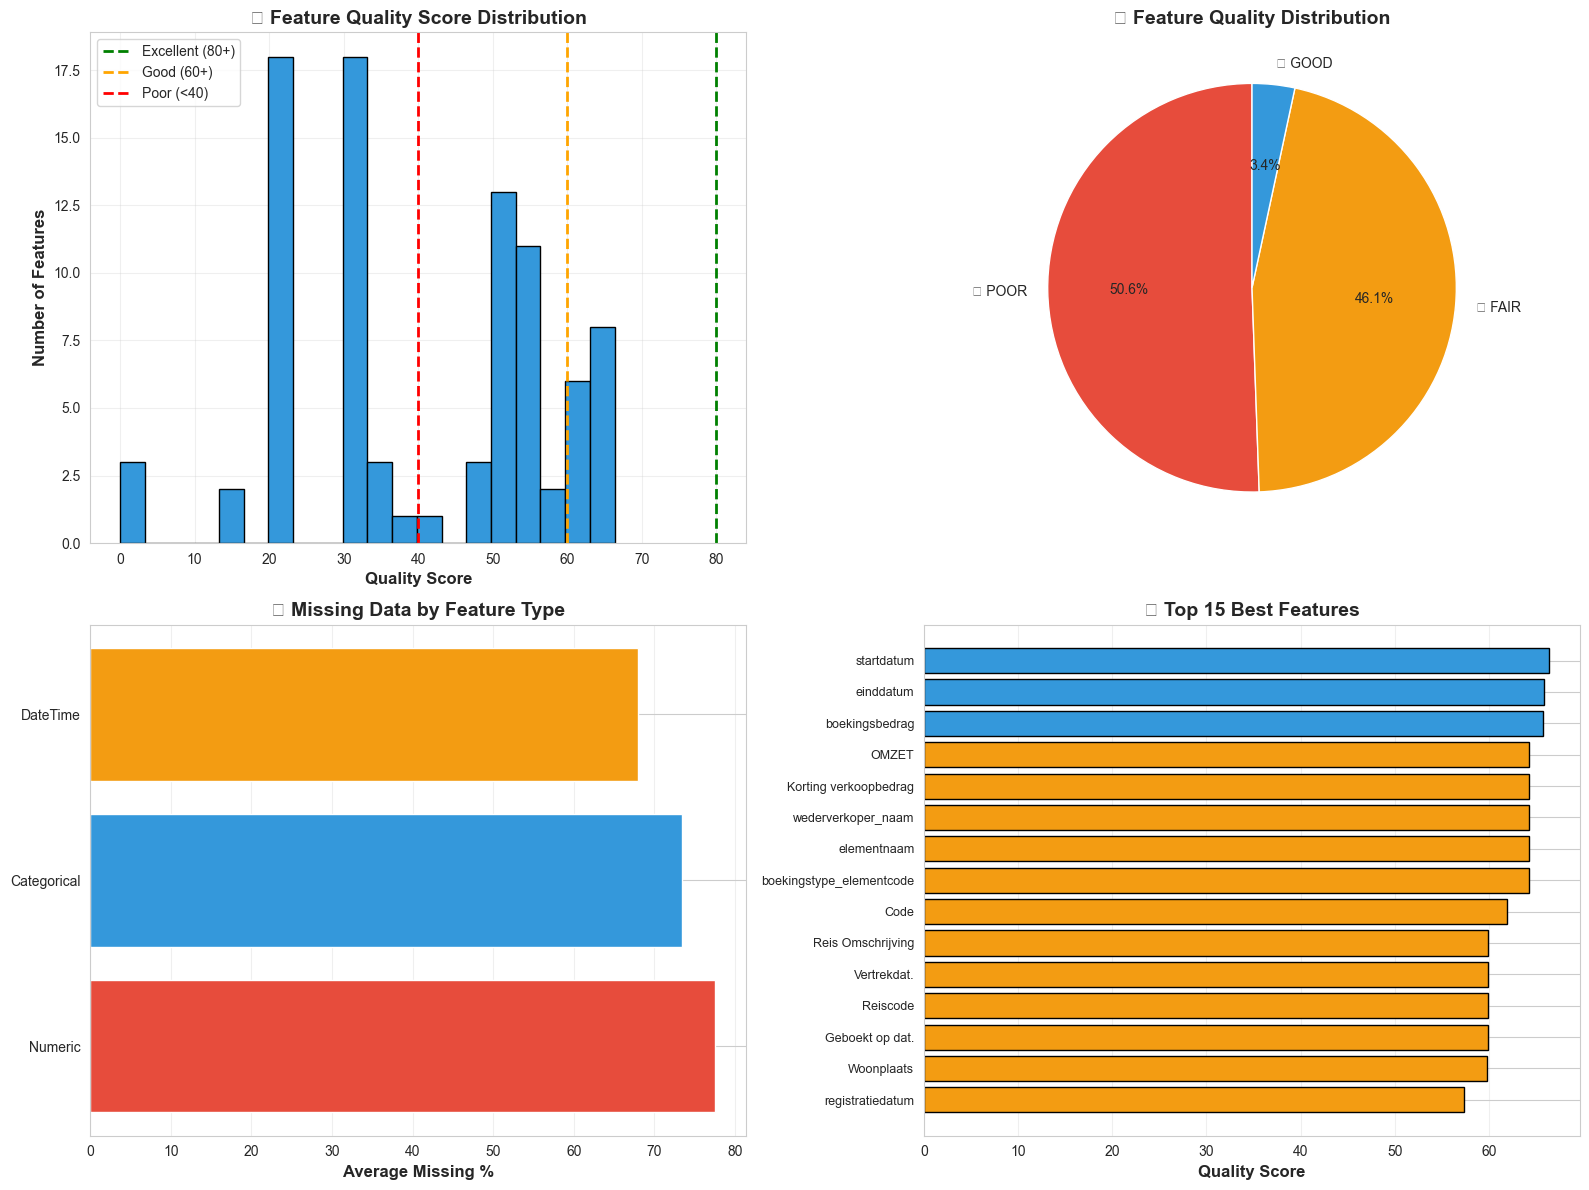


✅ Visualizations created!


In [13]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Quality Score Distribution
axes[0, 0].hist(features_df['Quality Score'], bins=20, color='#3498db', edgecolor='black')
axes[0, 0].axvline(x=80, color='green', linestyle='--', linewidth=2, label='Excellent (80+)')
axes[0, 0].axvline(x=60, color='orange', linestyle='--', linewidth=2, label='Good (60+)')
axes[0, 0].axvline(x=40, color='red', linestyle='--', linewidth=2, label='Poor (<40)')
axes[0, 0].set_xlabel('Quality Score', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Number of Features', fontsize=12, fontweight='bold')
axes[0, 0].set_title('📊 Feature Quality Score Distribution', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 2: Recommendation Breakdown
recommendation_counts = features_df['Recommendation'].value_counts()
colors_pie = {'✅ EXCELLENT': '#2ecc71', '🟢 GOOD': '#3498db', '🟡 FAIR': '#f39c12', '❌ POOR': '#e74c3c'}
colors_list = [colors_pie.get(x, '#95a5a6') for x in recommendation_counts.index]
axes[0, 1].pie(recommendation_counts.values, labels=recommendation_counts.index, 
               autopct='%1.1f%%', colors=colors_list, startangle=90)
axes[0, 1].set_title('🎯 Feature Quality Distribution', fontsize=14, fontweight='bold')

# Plot 3: Missing Data by Feature Type
type_missing = features_df.groupby('Type')['Missing %'].mean().sort_values(ascending=False)
axes[1, 0].barh(type_missing.index, type_missing.values, color=['#e74c3c', '#3498db', '#f39c12'])
axes[1, 0].set_xlabel('Average Missing %', fontsize=12, fontweight='bold')
axes[1, 0].set_title('📉 Missing Data by Feature Type', fontsize=14, fontweight='bold')
axes[1, 0].grid(alpha=0.3, axis='x')

# Plot 4: Top 15 Best Features
top_features = features_df.head(15)
colors_bar = [colors_pie.get(x, '#95a5a6') for x in top_features['Recommendation']]
axes[1, 1].barh(range(len(top_features)), top_features['Quality Score'], 
                color=colors_bar, edgecolor='black')
axes[1, 1].set_yticks(range(len(top_features)))
axes[1, 1].set_yticklabels(top_features['Feature'], fontsize=9)
axes[1, 1].set_xlabel('Quality Score', fontsize=12, fontweight='bold')
axes[1, 1].set_title('🏆 Top 15 Best Features', fontsize=14, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n✅ Visualizations created!")

---
## 🔗 Section 6: Analyze Which Features Work Together (Correlations)

Let's see which features are related to each other!

In [14]:
print("\n" + "="*80)
print("🔗 ANALYZING FEATURE RELATIONSHIPS")
print("="*80)

# Get numeric features only
numeric_features = features_df[features_df['Type'] == 'Numeric']['Feature'].tolist()
numeric_data = combined[numeric_features]

print(f"\n📊 Found {len(numeric_features)} numeric features")

if len(numeric_features) > 1:
    # Calculate correlation matrix
    correlation_matrix = numeric_data.corr()
    
    # Find strong correlations (>0.7 or <-0.7, excluding diagonal)
    print("\n🔍 Strong Correlations (|correlation| > 0.7):\n")
    
    strong_correlations = []
    for i in range(len(correlation_matrix)):
        for j in range(i+1, len(correlation_matrix)):
            corr_value = correlation_matrix.iloc[i, j]
            if abs(corr_value) > 0.7 and not pd.isna(corr_value):
                feature1 = correlation_matrix.index[i]
                feature2 = correlation_matrix.columns[j]
                strong_correlations.append({
                    'Feature 1': feature1,
                    'Feature 2': feature2,
                    'Correlation': corr_value,
                    'Strength': 'Very Strong' if abs(corr_value) > 0.9 else 'Strong'
                })
    
    if strong_correlations:
        corr_df = pd.DataFrame(strong_correlations)
        corr_df = corr_df.sort_values('Correlation', key=abs, ascending=False)
        corr_df['Correlation'] = corr_df['Correlation'].apply(lambda x: f"{x:.3f}")
        print(corr_df.to_string(index=False))
        
        print(f"\n💡 Found {len(corr_df)} pairs of strongly correlated features!")
        print("   → These features work together and provide similar information")
        print("   → Consider keeping only one from each pair to avoid redundancy")
    else:
        print("No strong correlations found (|r| > 0.7)")
        print("Most features are independent!")
    
    # Create correlation heatmap for top features
    if len(numeric_features) > 2:
        print("\n📊 Creating correlation heatmap...")
        
        # Select top numeric features (by quality)
        top_numeric = features_df[
            (features_df['Type'] == 'Numeric') & 
            (features_df['Recommendation'].isin(['✅ EXCELLENT', '🟢 GOOD']))
        ]['Feature'].head(15).tolist()
        
        if len(top_numeric) > 1:
            plt.figure(figsize=(12, 10))
            
            corr_matrix_top = combined[top_numeric].corr()
            
            # Create mask for upper triangle
            mask = np.triu(np.ones_like(corr_matrix_top, dtype=bool))
            
            sns.heatmap(corr_matrix_top, mask=mask, annot=True, fmt='.2f', 
                       cmap='coolwarm', center=0, vmin=-1, vmax=1,
                       square=True, linewidths=1, cbar_kws={"shrink": 0.8})
            
            plt.title('🔗 Feature Correlation Heatmap\n(Top Quality Numeric Features)', 
                     fontsize=14, fontweight='bold', pad=20)
            plt.tight_layout()
            plt.show()
        
else:
    print("\n⚠️ Not enough numeric features for correlation analysis")

print("\n" + "="*80)


🔗 ANALYZING FEATURE RELATIONSHIPS

📊 Found 34 numeric features

🔍 Strong Correlations (|correlation| > 0.7):

      Feature 1                Feature 2 Correlation    Strength
 boekingsbedrag boekingswaarde deelnemer       1.000 Very Strong
 boekingsbedrag                    OMZET       1.000 Very Strong
 BoekingsNummer               BoekingsID       0.999 Very Strong
   VERTREKMAAND              nw boekjaar       0.998 Very Strong
Actie 1 (prijs)           Reissom Totaal       0.896      Strong

💡 Found 5 pairs of strongly correlated features!
   → These features work together and provide similar information
   → Consider keeping only one from each pair to avoid redundancy

📊 Creating correlation heatmap...



---
## 🎯 Section 7: Final Feature Selection Recommendations

Let's create the final list of recommended features for your model!

In [15]:
print("\n" + "="*100)
print("🎯 FINAL FEATURE RECOMMENDATIONS FOR MODELING")
print("="*100)

# Get recommended features
recommended = features_df[features_df['Recommendation'].isin(['✅ EXCELLENT', '🟢 GOOD'])].copy()

print(f"\n✅ RECOMMENDED FEATURES ({len(recommended)} total):\n")

# Show by category
for feature_type in ['Numeric', 'Categorical', 'DateTime']:
    type_features = recommended[recommended['Type'] == feature_type]
    if len(type_features) > 0:
        print(f"\n{feature_type} Features ({len(type_features)}):")
        print("-" * 80)
        for idx, row in type_features.iterrows():
            print(f"  {row['Recommendation']} {row['Feature']}")
            print(f"       Quality: {row['Quality Score']:.1f}, Missing: {row['Missing %']:.1f}%, Unique: {row['Unique']}")

# Features to avoid
avoid = features_df[features_df['Recommendation'] == '❌ POOR']
print(f"\n\n❌ FEATURES TO AVOID ({len(avoid)} total):")
print("-" * 80)
if len(avoid) > 0:
    avoid_display = avoid[['Feature', 'Missing %', 'Quality Score']].head(10)
    avoid_display['Missing %'] = avoid_display['Missing %'].apply(lambda x: f"{x:.1f}%")
    avoid_display['Quality Score'] = avoid_display['Quality Score'].apply(lambda x: f"{x:.1f}")
    print(avoid_display.to_string(index=False))
    if len(avoid) > 10:
        print(f"\n... and {len(avoid) - 10} more poor quality features")
    print("\n💡 These features have too much missing data or are constant/IDs")

print("\n" + "="*100)
print("\n📋 SUMMARY:")
print("="*100)
print(f"✅ Total features available: {len(features_df)}")
print(f"✅ Recommended for modeling: {len(recommended)}")
print(f"❌ Not recommended: {len(avoid)}")
print(f"\n📊 Feature types in recommended set:")
print(f"   - Numeric: {len(recommended[recommended['Type'] == 'Numeric'])}")
print(f"   - Categorical: {len(recommended[recommended['Type'] == 'Categorical'])}")
print(f"   - DateTime: {len(recommended[recommended['Type'] == 'DateTime'])}")

print("\n" + "="*100)
print("\n💡 NEXT STEPS:")
print("="*100)
print("""
1️⃣ **Use EXCELLENT features first** - These are your strongest predictors

2️⃣ **Add GOOD features** - These will improve your model

3️⃣ **Handle missing data:**
   → Numeric: Use median/mean imputation or algorithms that handle NaNs
   → Categorical: Use mode or create 'Unknown' category
   → Or try algorithms like XGBoost/LightGBM that handle missing data

4️⃣ **Check correlations** - Remove redundant features that are highly correlated

5️⃣ **Encode categorical features:**
   → One-hot encoding for few categories (<10)
   → Label encoding for ordinal data
   → Target encoding for many categories (>10)

6️⃣ **Feature engineering from DateTime:**
   → Extract: year, month, day, day_of_week, quarter
   → Create: is_weekend, season, days_since_X

7️⃣ **Scale numeric features** if needed (for algorithms like SVM, Neural Nets)
""")
print("="*100)


🎯 FINAL FEATURE RECOMMENDATIONS FOR MODELING

✅ RECOMMENDED FEATURES (3 total):


Numeric Features (1):
--------------------------------------------------------------------------------
  🟢 GOOD boekingsbedrag
       Quality: 65.8, Missing: 48.9%, Unique: 7218

DateTime Features (2):
--------------------------------------------------------------------------------
  🟢 GOOD startdatum
       Quality: 66.4, Missing: 48.1%, Unique: 691
  🟢 GOOD einddatum
       Quality: 65.9, Missing: 48.8%, Unique: 702


❌ FEATURES TO AVOID (45 total):
--------------------------------------------------------------------------------
              Feature Missing % Quality Score
             Discount     74.9%          38.6
       rapportageweek     51.0%          34.3
           Agent alg.     94.4%          34.0
               Action     94.8%          33.7
            reis naam     97.1%          32.1
 boekingselement code     97.1%          32.1
leeftijd tijdens reis     97.1%          32.0
      Actie 

---
## 💾 Section 8: Save Results

Let's save everything for future use!

In [16]:
print("\n" + "="*80)
print("💾 SAVING RESULTS")
print("="*80)

# 1. Save the combined dataset
combined.to_csv('combined_all_datasets.csv', index=False)
print(f"\n✅ Combined dataset saved: 'combined_all_datasets.csv'")
print(f"   Size: {len(combined):,} rows × {len(combined.columns)} columns")

# 2. Save feature analysis
features_df.to_csv('feature_quality_analysis.csv', index=False)
print(f"\n✅ Feature analysis saved: 'feature_quality_analysis.csv'")

# 3. Save recommended features list
recommended_list = recommended['Feature'].tolist()
with open('recommended_features.txt', 'w') as f:
    f.write('\n'.join(recommended_list))
print(f"\n✅ Recommended features saved: 'recommended_features.txt'")
print(f"   {len(recommended_list)} features")

# 4. Save features to avoid
avoid_list = avoid['Feature'].tolist()
with open('features_to_avoid.txt', 'w') as f:
    f.write('\n'.join(avoid_list))
print(f"\n✅ Features to avoid saved: 'features_to_avoid.txt'")
print(f"   {len(avoid_list)} features")

# 5. Save correlation pairs if any
if 'corr_df' in locals() and len(corr_df) > 0:
    corr_df.to_csv('strong_correlations.csv', index=False)
    print(f"\n✅ Correlation analysis saved: 'strong_correlations.csv'")
    print(f"   {len(corr_df)} correlation pairs")

print("\n" + "="*80)
print("\n🎉 ALL DONE! You now have:")
print("="*80)
print("""
✅ One combined dataset with ALL features from all 6 datasets
✅ Complete quality analysis of ALL features
✅ Clear recommendations on which features to use
✅ Analysis of which features work together (correlations)
✅ Everything saved for your model development!
""")
print("="*80)
print("\n🚀 Ready to build your machine learning model!")
print("="*80)


💾 SAVING RESULTS

✅ Combined dataset saved: 'combined_all_datasets.csv'
   Size: 54,825 rows × 89 columns

✅ Feature analysis saved: 'feature_quality_analysis.csv'

✅ Recommended features saved: 'recommended_features.txt'
   3 features

✅ Features to avoid saved: 'features_to_avoid.txt'
   45 features

✅ Correlation analysis saved: 'strong_correlations.csv'
   5 correlation pairs


🎉 ALL DONE! You now have:

✅ One combined dataset with ALL features from all 6 datasets
✅ Complete quality analysis of ALL features
✅ Clear recommendations on which features to use
✅ Analysis of which features work together (correlations)
✅ Everything saved for your model development!


🚀 Ready to build your machine learning model!
